In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
%matplotlib notebook

In [23]:
vector_data = np.loadtxt("vectorgeom-01052014.csv", delimiter=',')
ow_data = np.loadtxt("ow-01052014.csv", delimiter=',')
normal_data = np.loadtxt("normal-01052014.csv", delimiter=',')
winding_data = np.loadtxt("windingangle-01052014.csv", delimiter=',')

real_data = pd.read_csv("validation_data/01052014.csv")
real_data = real_data[["Lat","Lon"]].to_numpy()
real_data = real_data[(real_data[:,1] > -30) & (real_data[:,1] < -20) & (real_data[:,0] > 20) & (real_data[:,0] < 60)]
print(real_data)

[[ 45.74766207 -29.81501637]
 [ 54.23161192 -29.81823487]
 [ 23.96590157 -29.4745845 ]
 [ 40.0602014  -29.33744292]
 [ 59.89574302 -29.4544539 ]
 [ 28.43535032 -29.20951792]
 [ 31.85409676 -28.86390434]
 [ 35.9737873  -29.03369706]
 [ 38.00517313 -28.78413629]
 [ 56.22594967 -28.84158854]
 [ 47.38629658 -28.51422214]
 [ 25.23203752 -28.22224475]
 [ 51.75798351 -28.39062069]
 [ 21.36524349 -27.93492587]
 [ 37.43139773 -27.52467735]
 [ 53.15242789 -27.45309955]
 [ 44.56228388 -27.18828034]
 [ 31.18796261 -26.99689937]
 [ 54.89572356 -26.9563776 ]
 [ 22.16597827 -26.88734038]
 [ 41.89934394 -26.68018756]
 [ 48.21777444 -26.44086887]
 [ 53.49623452 -26.39895716]
 [ 24.93053522 -26.2365122 ]
 [ 29.32420071 -26.2456986 ]
 [ 44.71485577 -26.2327944 ]
 [ 33.51641555 -26.09545245]
 [ 59.01174033 -25.91989471]
 [ 23.50393502 -25.56819624]
 [ 55.71294915 -25.5129798 ]
 [ 20.29403967 -25.04284942]
 [ 48.67924656 -24.75441837]
 [ 38.52381134 -24.5119477 ]
 [ 52.19863332 -24.80380494]
 [ 57.30878128

<IPython.core.display.Javascript object>


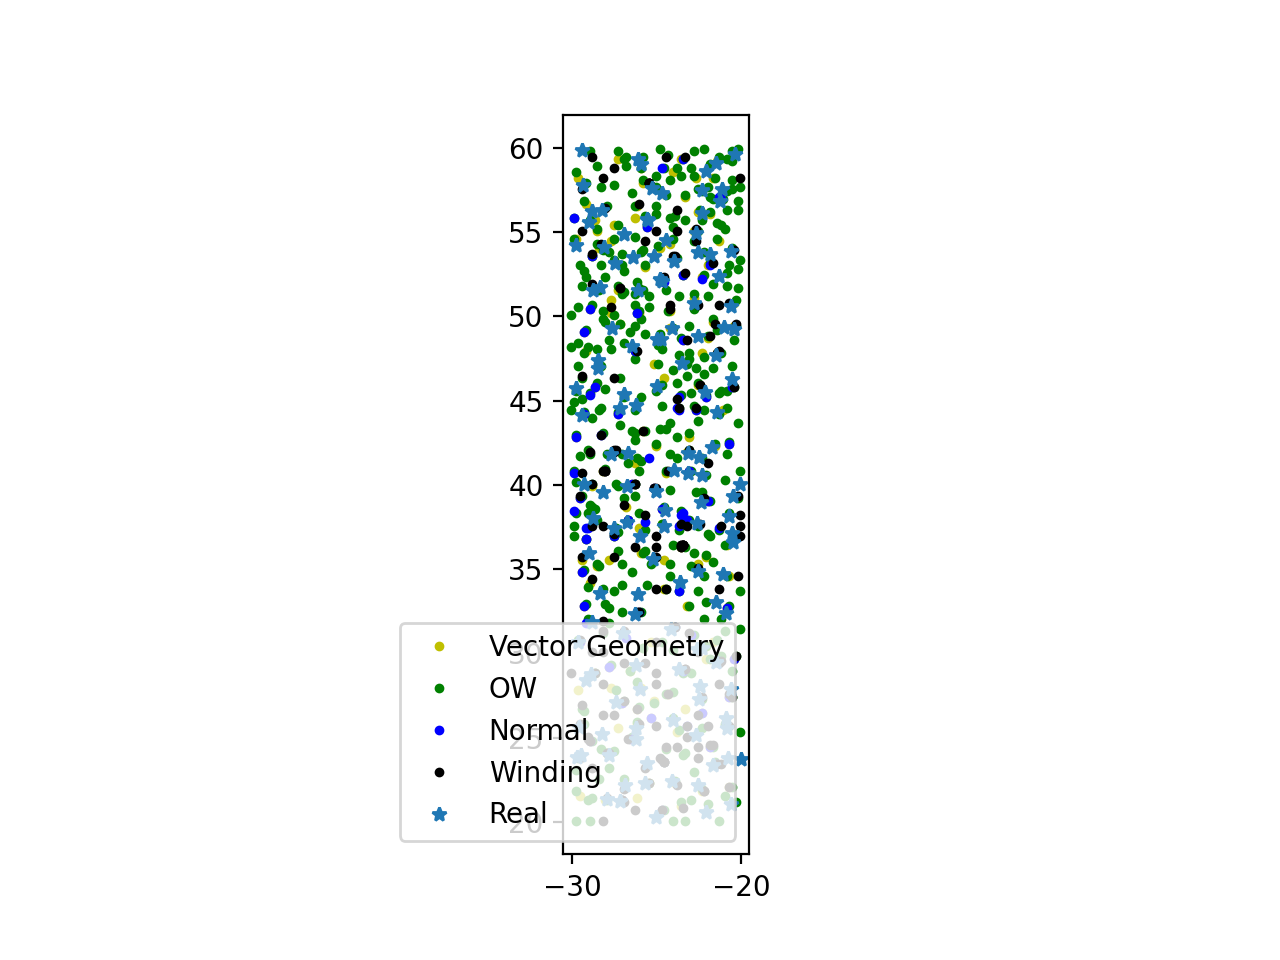

In [24]:
plt.figure(dpi=200)
plt.plot(vector_data[:,1],vector_data[:,0],'y.', markersize=5, label='Vector Geometry')
plt.plot(ow_data[:,1],ow_data[:,0],'g.', markersize=5, label='OW')
plt.plot(normal_data[:,1],normal_data[:,0],'b.', markersize=5, label='Normal')
plt.plot(winding_data[:,1],winding_data[:,0],'k.', markersize=5, label='Winding')
plt.plot(real_data[:,1],real_data[:,0],'*', markersize=5, label='Real')
plt.gca().set_aspect('equal')
plt.legend()

In [27]:
from dataclasses import dataclass

from scipy.spatial import KDTree
from sklearn.metrics.pairwise import haversine_distances

@dataclass
class Method:
    name: str
    points: np.ndarray
    P: int = 0
    TP: int = 0
    FP: int = 0
        
    def compare(self, ground_truth: np.ndarray, dist_tol):
        '''dist_tol is in km'''
        self.P = ground_truth.shape[0]
        
        tree_detected = KDTree(self.points)
        dist, index = tree_detected.query(ground_truth[:,0:2])
        truth = np.deg2rad(ground_truth[:,0:2])
        detected = np.deg2rad(self.points[index,:])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
        
        self.TP = (dist < dist_tol).sum()
        
        tree_truth = KDTree(ground_truth[:,0:2])
        dist, index = tree_truth.query(self.points)
        detected = np.deg2rad(ground_truth[index,0:2])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
                
        self.FP = (dist > dist_tol).sum()
    
    @property
    def TPR(self):
        return self.TP/self.P
    
    @property
    def FDR(self):
        return self.FP/self.P

    
tol = 50 #km THIS IS UP FOR DEBATE!
methods = [Method("OW", ow_data), Method("Winding", winding_data), Method("Vector Geometry", vector_data),
           Method("Normal Method", normal_data)]

for method in methods:
    method.compare(real_data, tol)
    print(f"{method.name=}, {method.TPR=}, {method.FDR=}")

method.name='OW', method.TPR=0.8208955223880597, method.FDR=0.9925373134328358
method.name='Winding', method.TPR=0.43283582089552236, method.FDR=1.0
method.name='Vector Geometry', method.TPR=0.5671641791044776, method.FDR=1.0
method.name='Normal Method', method.TPR=0.208955223880597, method.FDR=0.5671641791044776
